# Problem Statement

X Education is a Ed-Tech company, who want to increase their conversion rate. For this they have provided past data of leads with data labels of weather the said lead has been converted or no.
The goal of this model is to score every lead and help the sales team identify `Hot Leads`, this will help them increase their `Lead Conversion Rate` and also effeciently use their limited resources.

## Importing the required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Importing combinations 
from itertools import combinations 

import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics
from shapely.geometry import LineString
from sklearn.metrics import precision_recall_curve

# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

# Setting display opyions
pd.options.display.max_columns = 50
plt.style.use('ggplot')

## Reading data and performing initial checks

In [2]:
# Reading data
df=pd.read_csv('Leads.csv')

# Checking the head of the data
df.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [3]:
# Checking the info of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

There appears to some missing values in the data that need to be handeled

In [4]:
# Checking the numerical data
df.describe()

,Lead Number,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Asymmetrique Activity Score,Asymmetrique Profile Score
count,9240.000000,9240.000000,9103.000000,9240.000000,9103.000000,5022.000000,5022.000000
mean,617188.435606,0.385390,3.445238,487.698268,2.362820,14.306252,16.344883
std,23405.995698,0.486714,4.854853,548.021466,2.161418,1.386694,1.811395
min,579533.000000,0.000000,0.000000,0.000000,0.000000,7.000000,11.000000
25%,596484.500000,0.000000,1.000000,12.000000,1.000000,14.000000,15.000000
50%,615479.000000,0.000000,3.000000,248.000000,2.000000,14.000000,16.000000
75%,637387.250000,1.000000,5.000000,936.000000,3.000000,15.000000,18.000000
max,660737.000000,1.000000,251.000000,2272.000000,55.000000,18.000000,20.000000


In [5]:
# Checking the dimension of the data
df.shape

(9240, 37)

## Functions

In [6]:
# Function to get missing value percentage 
def miss_val(df):
    x = 100*df.isnull().sum()/df.shape[0]
    return x[x>0].sort_values(ascending=False)


# Function that returns series object containing columns of a given DataFrame 
# and the counts of unique values in each column sorted in decending order 
def uni_val(data):
    return data.nunique().sort_values(ascending=False)


# Function that converts values of a given column from yes & no to 1 & 0 
def binary_map(column):
    return column.map({'Yes':1,'No':0})


# Function that returns top Correlations given a Dataframe(df), the requires number of top correlations(num) (default = 10)
# and name of the target variable if present in the Dataframe(default = ' '). 
# num = 10 would return the top 10 correlations in the data
def top_corr(data,num = 10,target_coll = ' '):
    req_col=data._get_numeric_data().columns.tolist()
    if target_coll in req_col:
        req_col.remove(target_coll)
    var_list=[]
    for i in combinations(data.columns,2):
        i=list(i)
        var_list.append(i)
    corr_df=pd.DataFrame(var_list,columns=['Var1','Var2'])
    corr_df['Correlations']=corr_df[['Var1','Var2']].apply(lambda x: data[list(x)].corr().iloc[1,0],axis=1)
    corr_df['Corr_abs']=corr_df['Correlations'].abs()
    # Returning a Dataframe whose values are sorted according to the absolute correlation values
    return corr_df.sort_values(by='Corr_abs',ascending=False).head(num)


# Function to get list of Columns that are in Top 10 correlations dataframe
def list_top_corr(df):
    y=[]
    (df['Var1']+','+df['Var2']).apply(lambda x: y.extend(x.split(',')))
    return list(set(y))


# Function to check the VIF values
def check_vif(x_train):
    vif = pd.DataFrame()
    X_train_new = x_train.drop(['const'], axis=1).copy(deep=True)
    X = X_train_new
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif


# This function plots the confusion matrix
def plot_confusion(confusion):
    plt.figure(figsize=(5,5))
    sns.set_style('white')
    plt.clf()
    plt.imshow(confusion, interpolation='nearest', cmap = 'Set3')
    classNames = ['Negative','Positive']
    plt.title('True Converted and Predicted Converted Confusion Matrix', fontsize=14)
    plt.ylabel('True Converted', fontsize=14)
    plt.xlabel('Predicted Converted', fontsize=14)
    plt.xticks([0,1], classNames, fontsize=12)
    plt.yticks([0,1], classNames, fontsize=12)
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(confusion[i][j]), fontsize=14, ha='center')
    plt.show()
    return None


# Function will return some metrics given actual and predicted
def get_metrics(actual , predicted):
    
    confusion = metrics.confusion_matrix(actual , predicted)
    Accuracy = metrics.accuracy_score(actual, predicted)
    
    TN = confusion[0,0]
    FN = confusion[1,0]
    FP = confusion[0,1]
    TP = confusion[1,1]
    
    Sensitivity = TP / float(TP + FN) # calculate Sensitivity
    Specificity = TN / float(FP + TN) # calculate specificity
    Precision   = metrics.precision_score(actual, predicted) # calculate Precision
    Recall      = metrics.recall_score(actual, predicted) # calculate Recall
    F1 = 2*(Precision*Recall)/(Precision+Recall)
    
     # Print the Metrics
    print (f'The Accuracy is    : {round (Accuracy,2)} ({Accuracy})')
    print (f'The Sensitivity is : {round (Sensitivity,2)} ({Sensitivity})')
    print (f'The Specificity is : {round (Specificity,2)} ({Specificity})')
    print (f'The Precision is   : {round (Precision, 2)} ({Precision})')
    print (f'The Recall is      : {round (Recall, 2)} ({Recall})')
    print (f'The f1 score is    : {round (F1, 2)} ({F1})')
    return None


# Function to plot the ROC
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    return None

## Checking Data Imbalance

In [7]:
# Storing the value counts of the converted column 
imbalance = df['Converted'].value_counts()

# Checking variable imbalance
imbalance

0    5679
1    3561
Name: Converted, dtype: int64

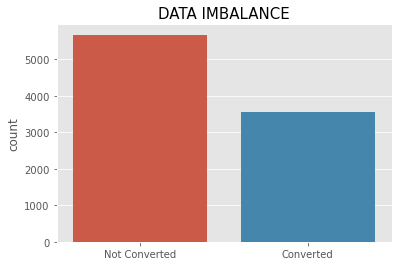

In [8]:
sns.countplot(x=df['Converted'])
plt.title('DATA IMBALANCE',fontsize=15)
plt.xlabel('')
plt.xticks(ticks=[0,1],labels=['Not Converted','Converted'])
plt.show()

In [9]:
# Calculating the imbalance ratio
round(imbalance[0]/imbalance[1],3)

1.595

We can clearly see that we have a, `0 : 1`, imbalance ratio of `1.595 : 1`  

## Conversion Rate of the given Data

In [10]:
# Calculating old conversion rate
old_conversion_rate = round(100*sum(df['Converted'])/len(df['Converted']),2)

# Displaying old conversion rate
old_conversion_rate

38.54

## EDA  (Data Inspection & Cleaning)

In [11]:
# Creating a new data frame so that original data is not altered
cleaned_df = df.copy(deep=True)

#### Handeling Missing Data

Accourding to the client there are categorical columns that have the value `'Select'` which is nothing but null value, given an option to the user to give this information they have choosen not to selected anything and so the value of such data points is stored as `'Select'`.

In [12]:
# Converting value 'Select' to null
cleaned_df = cleaned_df.replace('Select',np.nan)

# Geting percentage of missing values in each row after conversion
missing_values = miss_val(cleaned_df)

# Displaying only columns with missing values
missing_values

How did you hear about X Education               78.463203
Lead Profile                                     74.188312
Lead Quality                                     51.590909
Asymmetrique Profile Score                       45.649351
Asymmetrique Profile Index                       45.649351
Asymmetrique Activity Index                      45.649351
Asymmetrique Activity Score                      45.649351
City                                             39.707792
Specialization                                   36.580087
Tags                                             36.287879
What matters most to you in choosing a course    29.318182
What is your current occupation                  29.112554
Country                                          26.634199
Page Views Per Visit                              1.482684
TotalVisits                                       1.482684
Last Activity                                     1.114719
Lead Source                                       0.3896

 We can clearly observe that there are columns that have a very high number of missing values.
 
Droping columns having more than 40% missing data

In [13]:
# Dropping the above mentioned Columns
cleaned_df = cleaned_df.drop(missing_values[missing_values>40].index,axis=1)

# Getting missing values after dropping the columns
missing_values=miss_val(cleaned_df)

# Displaying the missing values
missing_values

City                                             39.707792
Specialization                                   36.580087
Tags                                             36.287879
What matters most to you in choosing a course    29.318182
What is your current occupation                  29.112554
Country                                          26.634199
Page Views Per Visit                              1.482684
TotalVisits                                       1.482684
Last Activity                                     1.114719
Lead Source                                       0.389610
dtype: float64

In [14]:
# Geting all the categorical columns for further analysis
temp = cleaned_df[missing_values.index].select_dtypes(object).columns

# Checking the value counts of categorical columns
for i in temp:
    print('---------------------------- '+i+' ----------------------------')
    print(cleaned_df[i].value_counts(dropna=False))
    print('--------------------------------------------------------------------')

---------------------------- City ----------------------------
NaN                            3669
Mumbai                         3222
Thane & Outskirts               752
Other Cities                    686
Other Cities of Maharashtra     457
Other Metro Cities              380
Tier II Cities                   74
Name: City, dtype: int64
--------------------------------------------------------------------
---------------------------- Specialization ----------------------------
NaN                                  3380
Finance Management                    976
Human Resource Management             848
Marketing Management                  838
Operations Management                 503
Business Administration               403
IT Projects Management                366
Supply Chain Management               349
Banking, Investment And Insurance     338
Media and Advertising                 203
Travel and Tourism                    203
International Business                178
Healthcare Man

- In the `City`,`Tags`,`What is your current occupation` and `Country` column we can clearly see that replacing the null values with mode value will skew the data, therefour replacing the null values with `Unknown`.
- Replacing all null values in `Specialization`,`What matters most to you in choosing a course`,`Last Activity` and `Lead Source` to `Other`.

**`DATA INCONSISTENCY`** - We can clearly see that under `Lead Source` **`Google`** and **`google`** are considered to be two different categories.

In [15]:
# Getting all numerical columns having missing values
temp = cleaned_df[missing_values.index].select_dtypes('number').columns

missing_values[temp]

Page Views Per Visit    1.482684
TotalVisits             1.482684
dtype: float64

We can see that there are very few missing values and therefore we can replace the missing values with median.

In [16]:
# Replacing with unknown
temp = ['City','Tags','Country','What is your current occupation']
cleaned_df[temp] = cleaned_df[temp].fillna('Unknown')


# Replacing with Other
temp = ['Specialization','What matters most to you in choosing a course'
        ,'Last Activity', 'Lead Source']
cleaned_df[temp] = cleaned_df[temp].fillna('Other')


# Correcting the Data Inconsistency found by changing the case of all the string values
cleaned_df['Lead Source']=cleaned_df['Lead Source'].apply(lambda x: x.title())


# Replacing missing values with median
cleaned_df[['Page Views Per Visit', 'TotalVisits']] = cleaned_df[['Page Views Per Visit', 'TotalVisits']].fillna(cleaned_df[[
                                                                            'Page Views Per Visit', 'TotalVisits']].median())

In [17]:
# Updating missing_values
missing_values=miss_val(cleaned_df)

# Displaying sorted missing values
missing_values

Series([], dtype: float64)

 We can clearly see that there are no missing values left in the data.

In [18]:
# Checking the dimension of the data
cleaned_df.shape

(9240, 30)

## Dropping unwanted columns

In [19]:
# Checking the info
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 30 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9240 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9240 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9240 

- `Lead number` help identify the lead, it does not have any numerical weight which can help us identify `Hot leads`, which is why we are droping these columns
- Data provided has both original data, provided by the user, and derived data, generated by the sales team based on some unknown calculations, unknown assumptions and personal intution, Therefour will drop the following columns:
    - Last Activity
    - Tags
    - Last Notable Activity

In [20]:
# Droping columns inplace
cleaned_df.drop(['Lead Number','Last Activity','Tags','Last Notable Activity'],axis=1,inplace=True)

In [21]:
# Getting number of unique values in each column
unique_val=uni_val(cleaned_df.select_dtypes(object))

# Checking unique_val variable
unique_val

Prospect ID                                      9240
Country                                            39
Lead Source                                        21
Specialization                                     19
City                                                7
What is your current occupation                     7
Lead Origin                                         5
What matters most to you in choosing a course       3
Search                                              2
Do Not Email                                        2
Do Not Call                                         2
A free copy of Mastering The Interview              2
Newspaper Article                                   2
X Education Forums                                  2
Newspaper                                           2
Digital Advertisement                               2
Through Recommendations                             2
I agree to pay the amount through cheque            1
Receive More Updates About O

We can clearly see that there are some columns where there is only one unique value which does not help in identifying and seperating the converted leads from the data, so we will drop such columns.

In [22]:
# Dropping columns with only 1 unique value
cleaned_df.drop(unique_val[unique_val.values==1].index,axis=1,inplace=True)

In [23]:
# Getting number of unique values in each column
unique_val=uni_val(cleaned_df.select_dtypes(object))

# Dropping Prospect ID from unique_val variable
unique_val.drop('Prospect ID',inplace=True)

# Checking unique_val variable
unique_val

Country                                          39
Lead Source                                      21
Specialization                                   19
City                                              7
What is your current occupation                   7
Lead Origin                                       5
What matters most to you in choosing a course     3
Search                                            2
Newspaper Article                                 2
X Education Forums                                2
Newspaper                                         2
Do Not Call                                       2
Do Not Email                                      2
Digital Advertisement                             2
Through Recommendations                           2
A free copy of Mastering The Interview            2
dtype: int64

#### Binning

In [24]:
# # Getting the columns to perform binning on
# unique_val[unique_val>2]

In [25]:
# # Selecting columns with more than 2 unique values
# temp = unique_val[unique_val>2].index

# # Checking the value counts
# for i in temp:
#     print('------------------- '+i+' -------------------------')
#     print(cleaned_df[i].value_counts(dropna=False))
#     print('----------------------------------------------------------')

- We will put all the countries other than India in to one group called `Foreign Countries`.
- Under `Lead Source` all the categories having less than 125 value counts will be grouped in to on category called `Other`
- In the column `What is your current occupation` groping `Students`,`Housewife`,`Businessman`,`Other` in to `Other`
- Groping `Lead Add Form` and `Quick Add Form` in to on group called `Form`, in the Lead Origin column
- Grouping `Flexibility & Convenience` with `Other` in the column `What matters most to you in choosing a course`

In [26]:
# Geting the value counts 
temp = cleaned_df['Country'].value_counts()

# Selecting the required categories 
req_categories = temp[temp<125].index

# Grouping
cleaned_df['Country'] = cleaned_df['Country'].apply(lambda x :'Foreign_Countries' if x in req_categories else x)

# Checking the value_counts
cleaned_df['Country'].value_counts()

India                6492
Unknown              2461
Foreign_Countries     287
Name: Country, dtype: int64

In [27]:
# Geting the value counts 
temp = cleaned_df['Lead Source'].value_counts()

# Selecting the required categories 
req_categories = temp[temp<125].index

# Grouping
cleaned_df['Lead Source'] = cleaned_df['Lead Source'].apply(lambda x :'Other' if x in req_categories else x)

# Checking the value_counts
cleaned_df['Lead Source'].value_counts()

Google              2873
Direct Traffic      2543
Olark Chat          1755
Organic Search      1154
Reference            534
Welingak Website     142
Referral Sites       125
Other                114
Name: Lead Source, dtype: int64

In [28]:
# Grouping
cleaned_df['What is your current occupation'].replace(['Student','Housewife','Businessman'],'Other',inplace=True)

# Checking the value_counts
cleaned_df['What is your current occupation'].value_counts()

Unemployed              5600
Unknown                 2690
Working Professional     706
Other                    244
Name: What is your current occupation, dtype: int64

In [29]:
# Grouping
cleaned_df['Lead Origin'].replace(['Quick Add Form','Lead Add Form'],'Form',inplace=True)

# Checking the value_counts
cleaned_df['Lead Origin'].value_counts()

Landing Page Submission    4886
API                        3580
Form                        719
Lead Import                  55
Name: Lead Origin, dtype: int64

In [30]:
# Grouping
cleaned_df['What matters most to you in choosing a course'].replace('Flexibility & Convenience','Other',inplace=True)

# Checking the value_counts
cleaned_df['What matters most to you in choosing a course'].value_counts()

Better Career Prospects    6528
Other                      2712
Name: What matters most to you in choosing a course, dtype: int64

#### Duplicates

In [31]:
# Checking for duplicated records
cleaned_df['Prospect ID'].duplicated().sum()

0

We can clearly see that there are no duplicate records in the data.

#### Handling Outliers

In [32]:
# Geting all the columns with numeric data type along with their value counts 
unique_val = uni_val(cleaned_df.select_dtypes('number'))

# Selecting columns with more than 2 unique values
# This will eleminate all the Yes No columns
unique_val = unique_val[unique_val>2]

# Checking unique_val variable
unique_val

Total Time Spent on Website    1731
Page Views Per Visit            114
TotalVisits                      41
dtype: int64

In [33]:
cleaned_df[unique_val.index].describe(percentiles=[0.25,0.5,0.75,0.9,0.95,0.97,0.99])

,Total Time Spent on Website,Page Views Per Visit,TotalVisits
count,9240.000000,9240.000000,9240.000000
mean,487.698268,2.357440,3.438636
std,548.021466,2.145781,4.819024
min,0.000000,0.000000,0.000000
25%,12.000000,1.000000,1.000000
50%,248.000000,2.000000,3.000000
75%,936.000000,3.000000,5.000000
90%,1380.000000,5.000000,7.000000
95%,1562.000000,6.000000,10.000000
97%,1660.000000,7.000000,11.000000


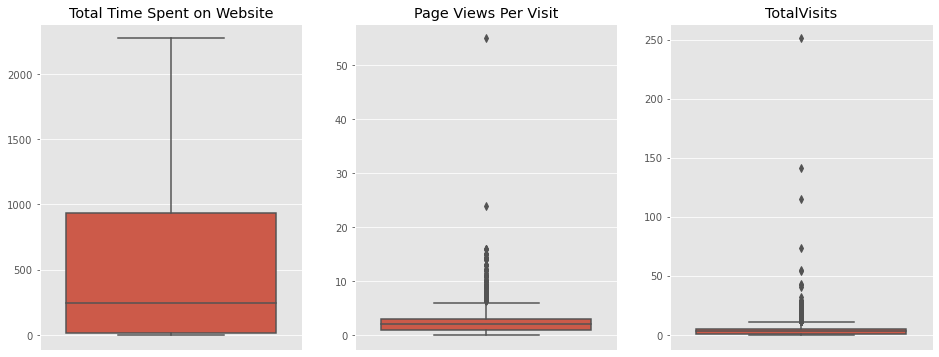

In [34]:
# Visualisation of outliers BEFORE CAPPING 

# Configuring figure and axis of subplots
fig, (ax1,ax2,ax3) = plt.subplots(1,3)

# Seting the figure size
fig.set_size_inches(16,6)

# Ploting the plots on their respective subplot
sns.boxplot(y = cleaned_df['Total Time Spent on Website'],ax=ax1,orient='v')
sns.boxplot(y = cleaned_df['Page Views Per Visit'],ax=ax2,orient='v')
sns.boxplot(y = cleaned_df['TotalVisits'],ax=ax3,orient='v')

# Setting the tick parameters for each subplots
ax1.tick_params(axis='x', which='both', length=0)
ax2.tick_params(axis='x', which='both', length=0)
ax3.tick_params(axis='x', which='both', length=0)

# Setting the title of each subplot
ax1.set(title = unique_val.index[0], ylabel='')
ax2.set(title = unique_val.index[1], ylabel='')
ax3.set(title = unique_val.index[2], ylabel='')

# Displaying the plots
plt.show()

- We can clearly observe that there are outliers in the **`Page Views Per Visit`** and **`Total Visits`** columns.
- Since there is a huge difference between the 97th, 99th and the 100th percentile values, we will cap the values at the value of the 97th percentile value.

In [35]:
# Loop on the columns having outliers
for col in unique_val.index[-2:]:
    
    # Geting the CAPPING VALLUE
    capping_percentile = cleaned_df[col].quantile(0.97)
    
    # CAPPING values greater that the capping_percentile
    cleaned_df[col][cleaned_df[col] >= capping_percentile] = capping_percentile

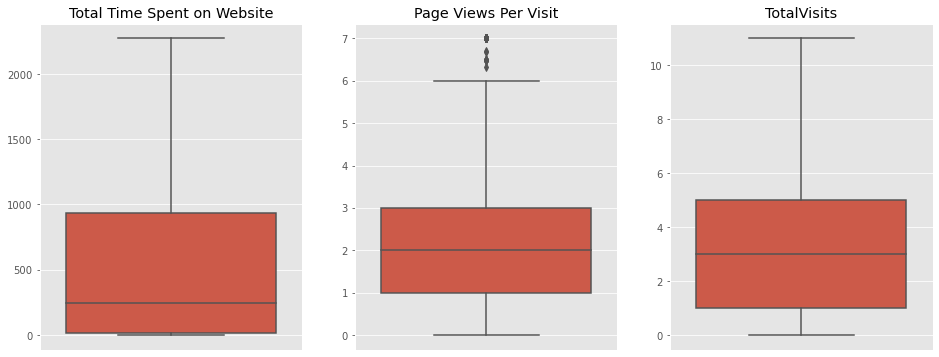

In [36]:
# Visualisation of outliers AFTER CAPPING 

# Configuring figure and axis of subplots
fig, (ax1,ax2,ax3) = plt.subplots(1,3)

# Seting the figure size
fig.set_size_inches(16,6)

# Ploting the plots on their respective subplot
sns.boxplot(y = cleaned_df['Total Time Spent on Website'],ax=ax1,orient='v')
sns.boxplot(y = cleaned_df['Page Views Per Visit'],ax=ax2,orient='v')
sns.boxplot(y = cleaned_df['TotalVisits'],ax=ax3,orient='v')

# Setting the tick parameters for each subplots
ax1.tick_params(axis='x', which='both', length=0)
ax2.tick_params(axis='x', which='both', length=0)
ax3.tick_params(axis='x', which='both', length=0)

# Setting the title of each subplot
ax1.set(title = unique_val.index[0], ylabel='')
ax2.set(title = unique_val.index[1], ylabel='')
ax3.set(title = unique_val.index[2], ylabel='')

# Displaying the plots
plt.show()

Even after capping the variables there still seems to be some outliers in the `Page Views Per Visit` column but these outliers seem to be in an acceptable range.

#### Visualisation

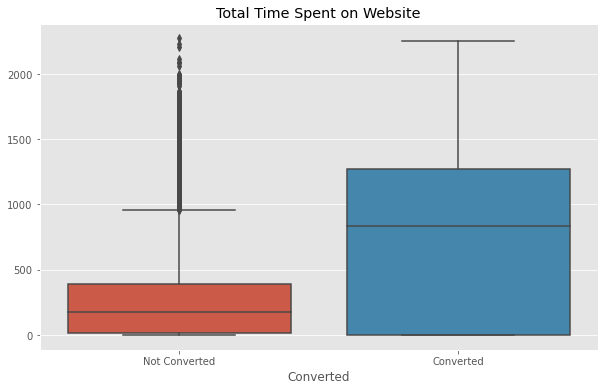

In [37]:
# Setting figure size
plt.figure(figsize=(10,6))

# Plotting boxplot using seaborn
sns.boxplot(x=cleaned_df['Converted'],y=cleaned_df['Total Time Spent on Website'])

# Giving a title
plt.title('Total Time Spent on Website')

# Removing unwanted labels
plt.ylabel('')

# Setting tick parameters
plt.xticks(ticks=[0,1],labels=['Not Converted','Converted'])

# Displaying the plot
plt.show()

**Inference -**
- We can clearly observe that the median time spent on the website is way higher for the people converted than the people not converted.
- We can observe a lot of outliers in the not converted category.
- Even though people converting spend more time, on average, we can see that there are people spending as much time as the people who are converted, but have not been converted. 

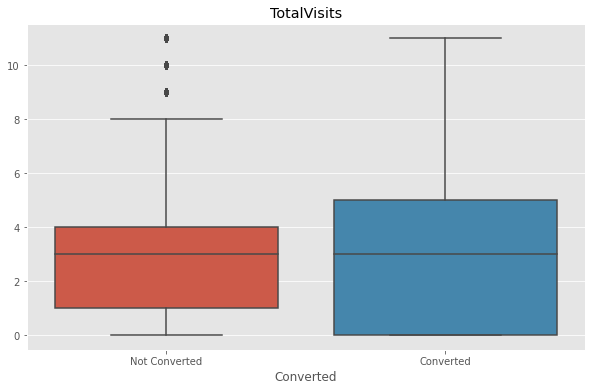

In [38]:
# Setting figure size
plt.figure(figsize=(10,6))

# Plotting boxplot using seaborn
sns.boxplot(x=cleaned_df['Converted'],y=cleaned_df['TotalVisits'])

# Giving a title
plt.title('TotalVisits')

# Removing unwanted labels
plt.ylabel('')

# Setting tick parameters
plt.xticks(ticks=[0,1],labels=['Not Converted','Converted'])

# Displaying the plot
plt.show()

**Inference -**
- On average(Median) we can clearly see that there is not much difference in the total visits in both the categories.
- The upper wisker in the converted category is higher that that of the not converted category.
- We can also observe some outliers in the not converted category when we take total visits in to consideration.

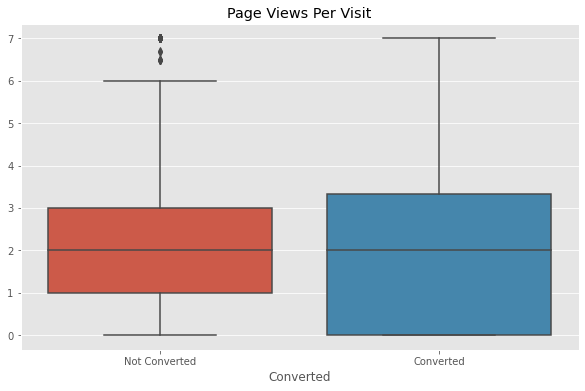

In [39]:
# Setting figure size
plt.figure(figsize=(10,6))

# Plotting boxplot using seaborn
sns.boxplot(x=cleaned_df['Converted'],y=cleaned_df['Page Views Per Visit'])

# Giving a title
plt.title('Page Views Per Visit')

# Removing unwanted labels
plt.ylabel('')

# Setting tick parameters
plt.xticks(ticks=[0,1],labels=['Not Converted','Converted'])

# Displaying the plot
plt.show()

**Inference -**
- On average(Median) we can clearly see that there is not much difference in the page views per visits in both the categories.
- The upper wisker in the converted category is higher that that of the not converted category.
- We can also observe some outliers in the not converted category when we take total visits in to consideration.

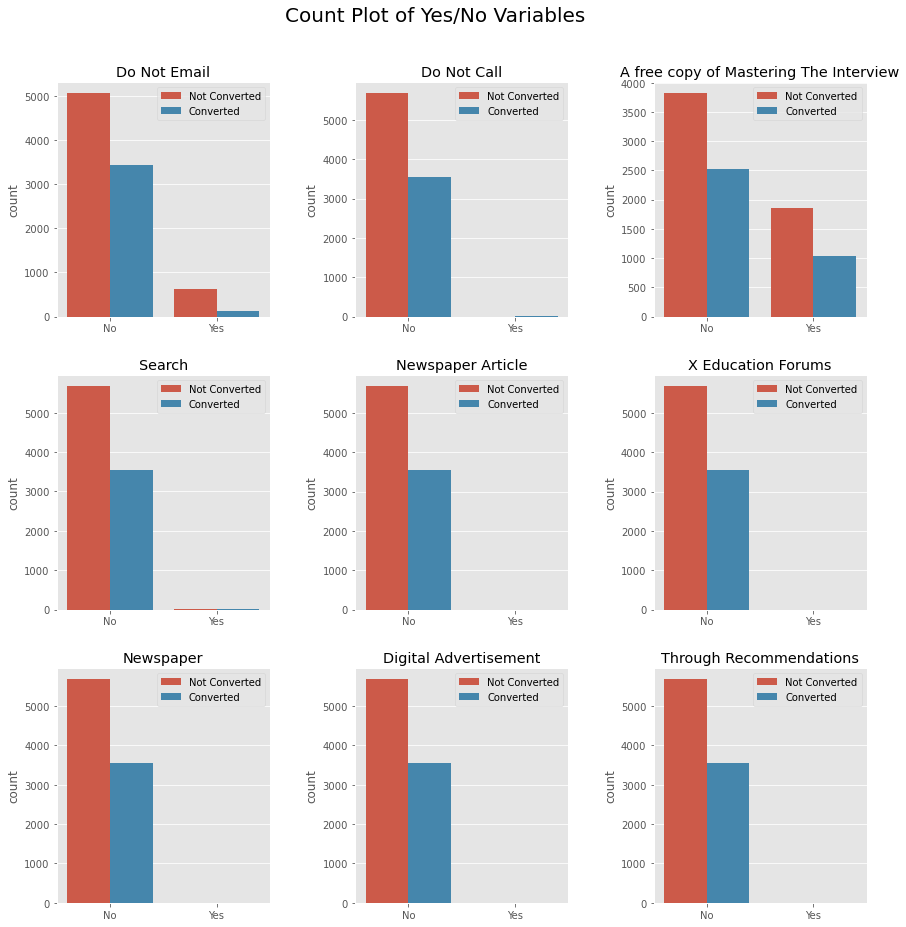

In [40]:
# Getting the categorical columns with their value counts
unique_val = uni_val(cleaned_df.select_dtypes('object'))

# Getting all the Yes/No columns
req_coll = unique_val[unique_val==2].drop('What matters most to you in choosing a course').index

# Reshaping the list of columns
req_coll = np.asarray(req_coll.tolist()).reshape(3,3)

# Setting figure and axis elements of the subplots
fig, axs = plt.subplots(3,3,figsize=(15,15))

# Giving a super title 
plt.suptitle('Count Plot of Yes/No Variables',fontsize=20)


# Runing a loop for getting the count plots of all yes/np columns
for i in range(0,3):
    for j in range(0,3):
        # Plotting countplot using seaborn
        sns.countplot(x=cleaned_df[req_coll[i,j]],hue=cleaned_df['Converted'],ax=axs[i,j])
        # Removing the xlabel
        axs[i,j].set_xlabel('')
        # Giving title to the subplot
        axs[i,j].title.set_text(req_coll[i,j])
        # Seting labels
        axs[i,j].legend(['Not Converted','Converted'])
        
# Adjusting the spaceing
plt.subplots_adjust(left=0.15,
                    bottom=0.15, 
                    right=0.9, 
                    top=0.91, 
                    wspace=0.4, 
                    hspace=0.25)

# Displaying the plot
plt.show()

**Inference -**
- We can clearly see that there are columns hat are heavely skewed, which are 'X Education Forums', 'Through Recommendations', 'Digital Advertisement', 'Newspaper', 'Newspaper Article', 'Search', 'Do Not Call' and 'Do Not Email' so will have to drop these columns 

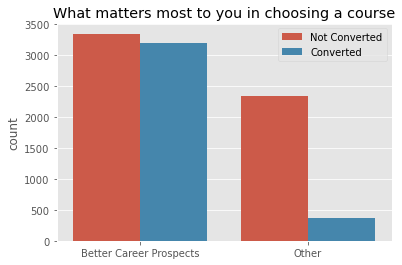

In [41]:
# ploting A free copy of Mastering The Interview
# Plotting countplot using seaborn
sns.countplot(x=cleaned_df['What matters most to you in choosing a course'],hue=cleaned_df['Converted'])
# Removing the xlabel
plt.xlabel('')
# Giving title to the subplot
plt.title('What matters most to you in choosing a course')
# Seting lengend
plt.legend(['Not Converted','Converted'])
# Displaying the plot
plt.show()

**Inference -**
- We can see that people who have an objective of 'Better career prospect' while taking X Education's services have a higher chance of converting.

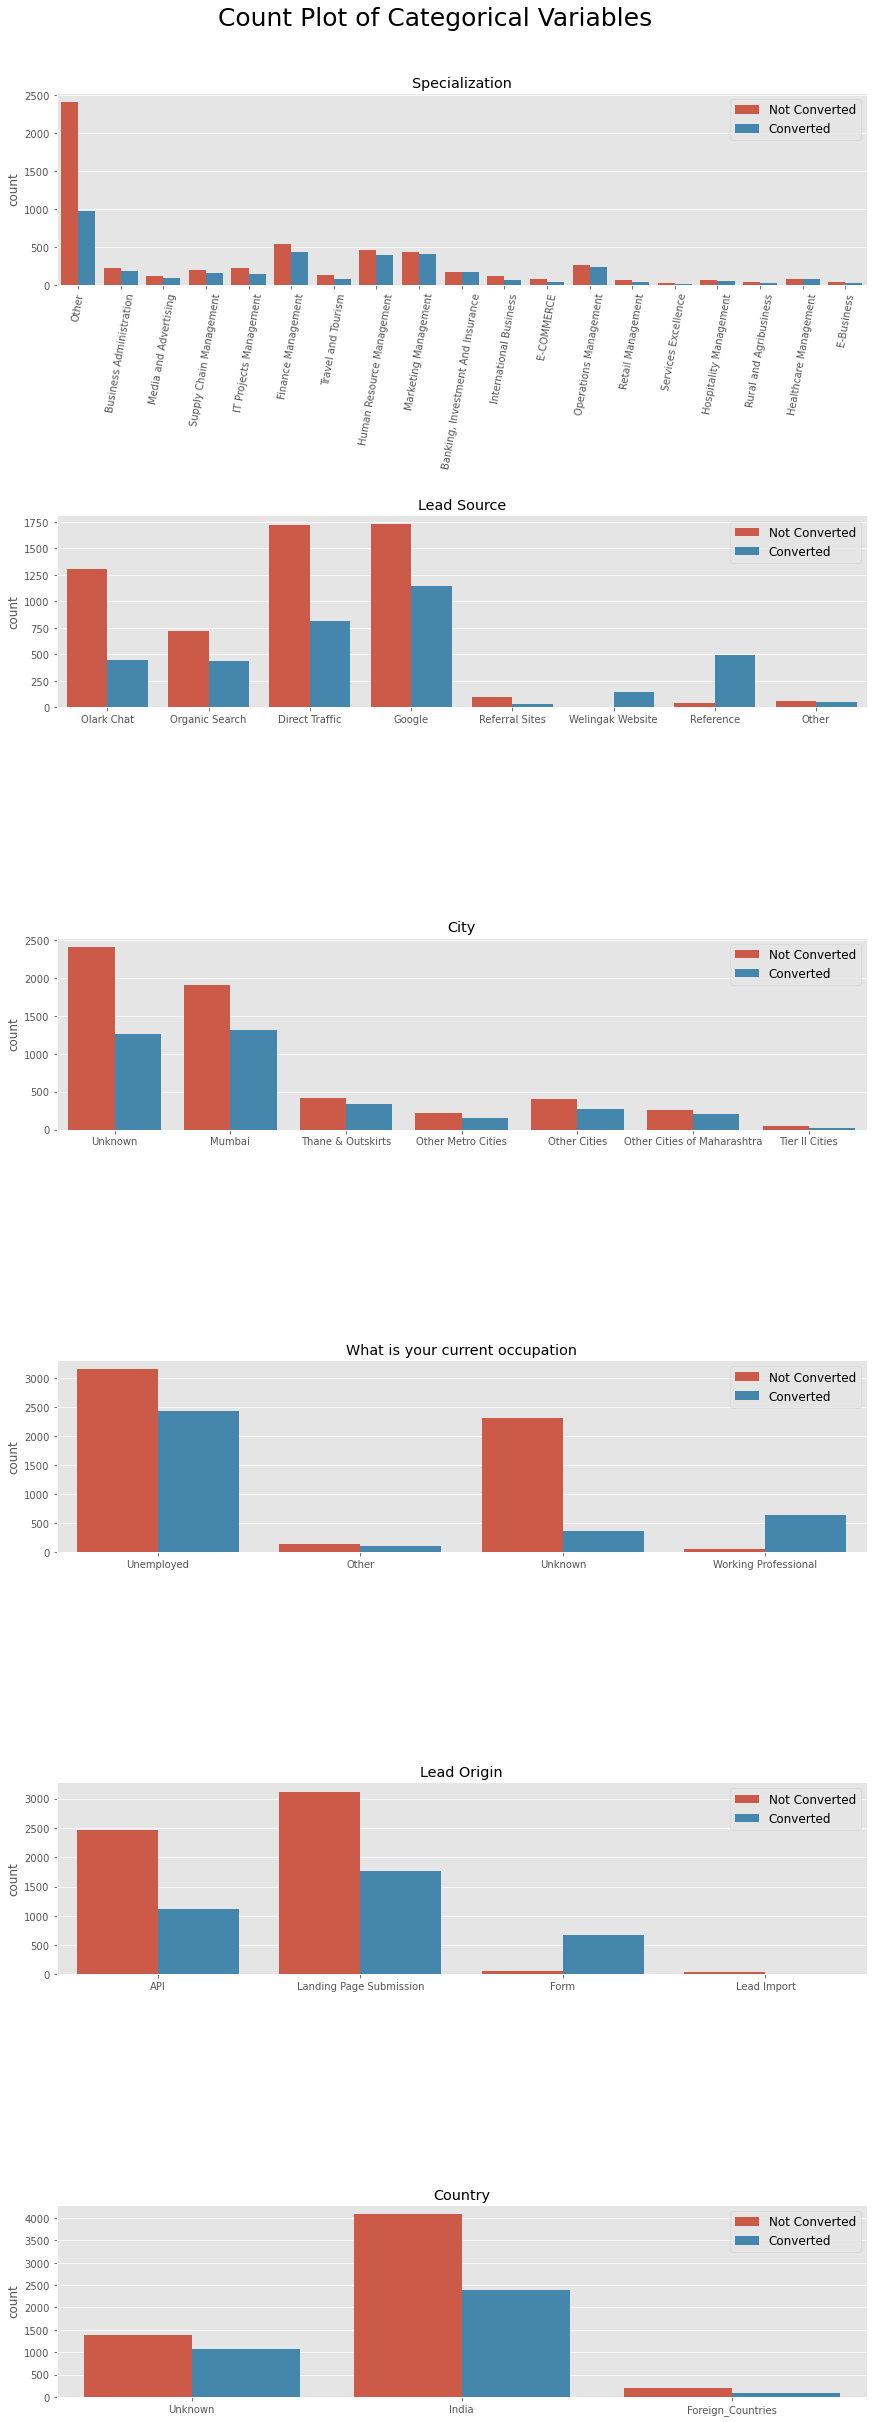

In [42]:
# Getting the categorical columns with their value counts
unique_val = uni_val(cleaned_df.select_dtypes('object'))

# Droping 'Prospect ID'
unique_val.drop('Prospect ID',inplace=True)

# Getting the required columns
req_coll = unique_val[unique_val>2].index

# Reshaping the list of columns
req_coll = np.asarray(req_coll.tolist()).reshape(6,1)

# Setting figure and axis elements of the subplots
fig, axs = plt.subplots(6,1,figsize=(15,40))

# Giving a super title 
plt.suptitle('Count Plot of Categorical Variables',fontsize=25)

# Runing a loop for getting the count plots of all yes/np columns
for i in range(0,6):
    # Plotting countplot using seaborn
    sns.countplot(x=cleaned_df[req_coll[i,0]],hue=cleaned_df['Converted'],ax=axs[i])
    # Removing the xlabel
    axs[i].set_xlabel('')
    # Giving title to the subplot
    axs[i].title.set_text(req_coll[i,0])
    # Making xticks visible/readable
    if len(axs[i].get_xticklabels())>8:
        axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=80)
    # Setting the legend
    axs[i].legend(labels = ['Not Converted','Converted'],loc='upper right',fontsize='large')


# Adjusting the spaceing
plt.subplots_adjust(left=0.15,
                    bottom=0.15, 
                    right=0.9, 
                    top=0.95, 
                    wspace=0.4, 
                    hspace=1.2)

# Displaying the plot
plt.show()

**Inference -**
- We can see from the count plot of 'Specialization' that if user has a specialization in any field then the chance of conversion id high.
- From the count plot of the 'Lead Source' column we can say that we are getting the highest leads from google when compaired to other lead sources.
- From the count plot of the city column, we can see that there are many users not giving their city name and therefore if these missing values were imputed then would skew the data towards the city of mumbai.
- When the count plot of the users ocupation is ploted we can observe that most of our users are unemployed, this also proves the fact that our users are looking for a better career prospect.
- Most of our leads originate from the landing page submission.
- We can observe that most of our user base is from India, we can also observe that there are many users that have not provided any information on the country they are from. Since, the values in it are skewed we would drop this column

In [43]:
# Dropping skewed columns
cleaned_df.drop(['X Education Forums','Through Recommendations',
                 'Digital Advertisement','Newspaper','Newspaper Article',
                 'Search','Do Not Call','Do Not Email','Country',
                 'What matters most to you in choosing a course'],axis=1,inplace=True)

In [44]:
# Geting only numeric data and dropping the target variable
req_coll = cleaned_df.select_dtypes('number').drop('Converted',axis=1).columns

# Getting the top correlations
correlation = top_corr(cleaned_df[req_coll])

# Displaying the DataFrame
correlation

,Var1,Var2,Correlations,Corr_abs
1,TotalVisits,Page Views Per Visit,0.756408,0.756408
0,TotalVisits,Total Time Spent on Website,0.351107,0.351107
2,Total Time Spent on Website,Page Views Per Visit,0.348707,0.348707


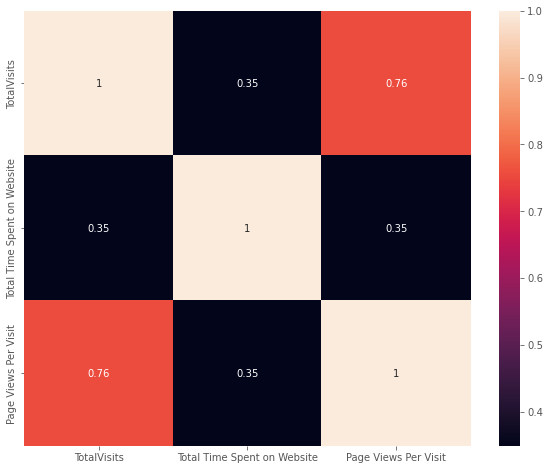

In [45]:
# Setting the figure size
plt.figure(figsize=(10,8))

# Plotting the heatmap using seaborn
sns.heatmap(cleaned_df[req_coll].corr(),annot=True)

# Vertical Alignment of yticks 
plt.yticks(va='center')

# Displaying the plot
plt.show()

Here we can see that there is a very high positive correlation between page views per visit and total visits 

## Data Preprocessing

#### Binary Maping
Here we are converting values, of all the columns having values of `Yes` & `No`, to `1` & `0`

In [46]:
# Getting number of unique values in each column
unique_val=uni_val(cleaned_df.select_dtypes(object))

# Dropping Prospect ID from unique_val variable
unique_val.drop('Prospect ID',inplace=True)

# Checking unique_val variable
unique_val

Specialization                            19
Lead Source                                8
City                                       7
What is your current occupation            4
Lead Origin                                4
A free copy of Mastering The Interview     2
dtype: int64

Now we map all the `Yes No` columns to `1 0` 

In [47]:
# Applying the binary maping function on all the yes no columns 
temp = unique_val[unique_val.values<3].index#.drop('What matters most to you in choosing a course').index
cleaned_df[temp] = cleaned_df[temp].apply(binary_map)

In [48]:
# Getting number of unique values in each column
unique_val=uni_val(cleaned_df.select_dtypes(object))

# Dropping Prospect ID from unique_val variable
unique_val.drop('Prospect ID',inplace=True)

# Checking unique_val variable
unique_val

Specialization                     19
Lead Source                         8
City                                7
What is your current occupation     4
Lead Origin                         4
dtype: int64

#### Dummy Variable Creation
Handeling all the categorical columns that have more than 2 unique values.

In [49]:
# Creating dummy variables for all the columns left in the unique_val
dummy = pd.get_dummies(cleaned_df[unique_val.index.tolist()],drop_first=True)

# # Droping categories in drop_after_dummy
# dummy.drop(drop_after_dummy,axis=1,inplace=True)

# Dropping the rows for which the dummy variables have been created
cleaned_df.drop(unique_val.index,axis=1,inplace=True)

# Adding the dummy variables to cleaned_df dataframe
cleaned_df = pd.concat([cleaned_df,dummy],axis=1)

In [50]:
# Checking the dimension of the data after dummification
cleaned_df.shape

(9240, 43)

In [51]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 43 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Prospect ID                                           9240 non-null   object 
 1   Converted                                             9240 non-null   int64  
 2   TotalVisits                                           9240 non-null   float64
 3   Total Time Spent on Website                           9240 non-null   int64  
 4   Page Views Per Visit                                  9240 non-null   float64
 5   A free copy of Mastering The Interview                9240 non-null   int64  
 6   Specialization_Business Administration                9240 non-null   uint8  
 7   Specialization_E-Business                             9240 non-null   uint8  
 8   Specialization_E-COMMERCE                             9240

#### Checking Correlation
Checking Top - 5 correlaions between features after creating dummy variables.

In [52]:
# Getting the top correlations
correlation = top_corr(cleaned_df.drop(['Prospect ID','Converted'],axis=1),15)

# Displaying the DataFrame
correlation

,Var1,Var2,Correlations,Corr_abs
726,Lead Source_Reference,Lead Origin_Form,0.852594,0.852594
537,Specialization_Other,City_Unknown,0.845374,0.845374
803,City_Unknown,Lead Origin_Landing Page Submission,-0.808285,0.808285
805,What is your current occupation_Unemployed,What is your current occupation_Unknown,-0.794875,0.794875
1,TotalVisits,Page Views Per Visit,0.756408,0.756408
542,Specialization_Other,Lead Origin_Landing Page Submission,-0.748263,0.748263
714,Lead Source_Other,Lead Origin_Lead Import,0.692356,0.692356
152,A free copy of Mastering The Interview,Lead Origin_Landing Page Submission,0.569633,0.569633
99,Page Views Per Visit,Lead Source_Olark Chat,-0.556134,0.556134
147,A free copy of Mastering The Interview,City_Unknown,-0.545297,0.545297


In [53]:
# List of columns present in the correlations DataFrame
req_coll = list_top_corr(correlation)

# Displaying the req_coll variable
req_coll

['City_Unknown',
 'What is your current occupation_Unknown',
 'Lead Origin_Landing Page Submission',
 'What is your current occupation_Unemployed',
 'Lead Origin_Lead Import',
 'Lead Source_Other',
 'A free copy of Mastering The Interview',
 'Page Views Per Visit',
 'Lead Source_Olark Chat',
 'Specialization_Other',
 'Lead Source_Reference',
 'TotalVisits',
 'Lead Origin_Form']

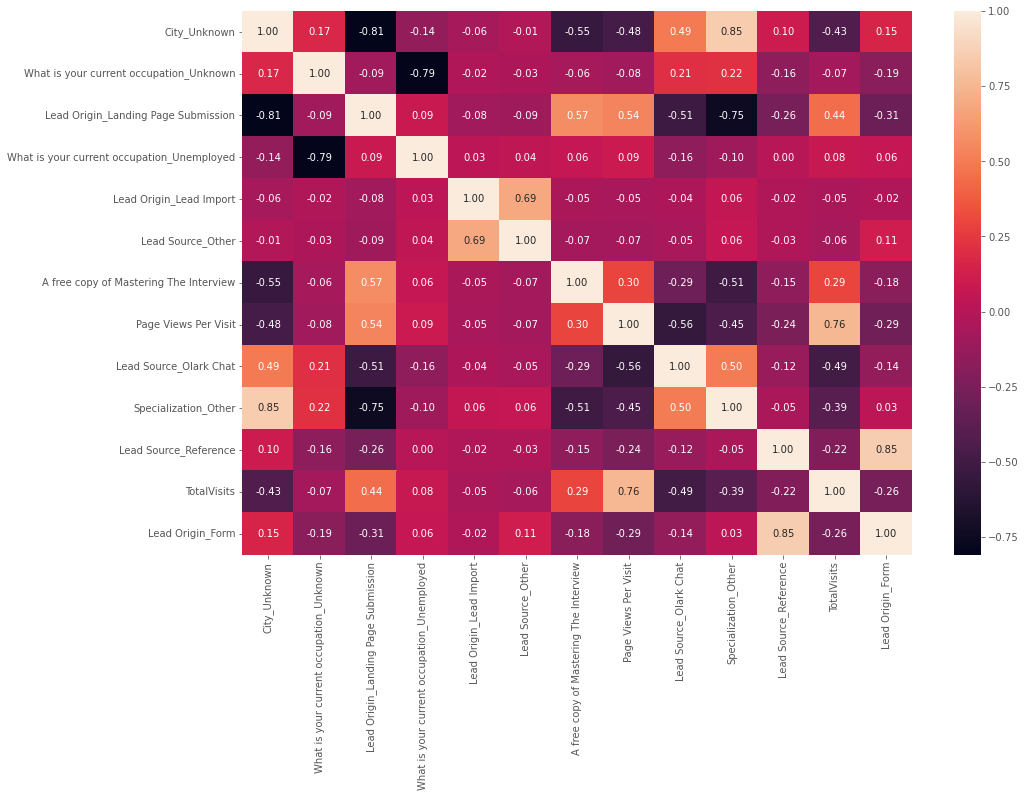

In [54]:
# Setting the figure size
plt.figure(figsize=(15,10))

# Plotting the heatmap using seaborn
sns.heatmap(cleaned_df[req_coll].corr(),annot=True,fmt='.2f')

# Vertical Alignment of yticks 
plt.yticks(va='center')

# Displaying the plot
plt.show()

#### Train - Test Split
Splitting the data into train and test data for model creation and evaluation.

In [55]:
# Removing the target variable 'Converted' from the data and asigning all the other variables to x
x =  cleaned_df.drop(['Converted','Prospect ID'],axis=1)

# Checking x  
x.shape

(9240, 41)

In [56]:
# Asigning the target variable 'Converted' to y
y = cleaned_df['Converted']

# Checking y
y.shape

(9240,)

In [57]:
# Splitting the data into x_train, y_train, x_test and y_test
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, test_size=0.3, random_state=100)

#### Feature Scaling
Scaling the float variables to bring values in the range of (0,1), this would help as we are using logestic regression.

In [58]:
# Initialising using StandardScaler
scaler = StandardScaler()

In [59]:
# Geting all the columns with numeric data type along with their value counts 
unique_val = uni_val(cleaned_df.select_dtypes('number'))

# Selecting columns with more than 2 unique values
# This will eleminate all the Yes No columns
unique_val = unique_val[unique_val>2]

# Columns that we are going to scale
list(unique_val.index)

['Total Time Spent on Website', 'Page Views Per Visit', 'TotalVisits']

In [60]:
# Scaling the columns 
x_train[unique_val.index] = scaler.fit_transform(x_train[unique_val.index])

# Chicking the Scaled variables
x_train[unique_val.index].describe()

,Total Time Spent on Website,Page Views Per Visit,TotalVisits
count,6.468000e+03,6.468000e+03,6.468000e+03
mean,-1.609377e-16,1.377308e-16,-1.798877e-17
std,1.000077e+00,1.000077e+00,1.000077e+00
min,-8.853708e-01,-1.227341e+00,-1.122305e+00
25%,-8.634138e-01,-6.897537e-01,-7.729250e-01
50%,-4.352528e-01,-1.521667e-01,-7.416494e-02
75%,8.098906e-01,3.854203e-01,6.245952e-01
max,3.271816e+00,2.535768e+00,2.720875e+00


In [61]:
# Checking the X_train 
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6468 entries, 1871 to 5640
Data columns (total 41 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   TotalVisits                                           6468 non-null   float64
 1   Total Time Spent on Website                           6468 non-null   float64
 2   Page Views Per Visit                                  6468 non-null   float64
 3   A free copy of Mastering The Interview                6468 non-null   int64  
 4   Specialization_Business Administration                6468 non-null   uint8  
 5   Specialization_E-Business                             6468 non-null   uint8  
 6   Specialization_E-COMMERCE                             6468 non-null   uint8  
 7   Specialization_Finance Management                     6468 non-null   uint8  
 8   Specialization_Healthcare Management                  6

## Building model

In [62]:
# Checking the dimensions of he data
x_train.shape

(6468, 41)

We can see that there are too many features, so we will use RFE for selecting the features.

#### Feature Selection using RFE

In [63]:
# Using LogisticRegression
log_reg = LogisticRegression()

# Initialization of RFE
rfe = RFE(log_reg,18)

In [64]:
# Running RFE over x_train and y_train 
rfe = rfe.fit(x_train,y_train)

# Checking the results obtained from RFE
list(zip(x_train.columns, rfe.support_, rfe.ranking_))

[('TotalVisits', False, 7),
 ('Total Time Spent on Website', True, 1),
 ('Page Views Per Visit', False, 13),
 ('A free copy of Mastering The Interview', True, 1),
 ('Specialization_Business Administration', False, 8),
 ('Specialization_E-Business', False, 15),
 ('Specialization_E-COMMERCE', False, 2),
 ('Specialization_Finance Management', False, 23),
 ('Specialization_Healthcare Management', False, 20),
 ('Specialization_Hospitality Management', True, 1),
 ('Specialization_Human Resource Management', False, 10),
 ('Specialization_IT Projects Management', False, 24),
 ('Specialization_International Business', True, 1),
 ('Specialization_Marketing Management', False, 11),
 ('Specialization_Media and Advertising', False, 22),
 ('Specialization_Operations Management', False, 17),
 ('Specialization_Other', True, 1),
 ('Specialization_Retail Management', True, 1),
 ('Specialization_Rural and Agribusiness', True, 1),
 ('Specialization_Services Excellence', False, 6),
 ('Specialization_Supply

In [65]:
# Storing the column names 
col = x_train.columns[rfe.support_]

In [66]:
# Columns that were removed by RFE
x_train.columns[~rfe.support_]

Index(['TotalVisits', 'Page Views Per Visit',
       'Specialization_Business Administration', 'Specialization_E-Business',
       'Specialization_E-COMMERCE', 'Specialization_Finance Management',
       'Specialization_Healthcare Management',
       'Specialization_Human Resource Management',
       'Specialization_IT Projects Management',
       'Specialization_Marketing Management',
       'Specialization_Media and Advertising',
       'Specialization_Operations Management',
       'Specialization_Services Excellence',
       'Specialization_Supply Chain Management',
       'Specialization_Travel and Tourism', 'Lead Source_Google',
       'Lead Source_Organic Search', 'Lead Source_Other', 'City_Other Cities',
       'City_Other Cities of Maharashtra', 'City_Other Metro Cities',
       'City_Thane & Outskirts', 'What is your current occupation_Unemployed'],
      dtype='object')

In [67]:
# Only keeping the features selected by RFE
x_train = x_train[col]

In [68]:
top_corr(x_train)

,Var1,Var2,Correlations,Corr_abs
114,Lead Source_Reference,Lead Origin_Form,0.861224,0.861224
69,Specialization_Other,City_Unknown,0.845912,0.845912
141,City_Unknown,Lead Origin_Landing Page Submission,-0.813817,0.813817
73,Specialization_Other,Lead Origin_Landing Page Submission,-0.751185,0.751185
31,A free copy of Mastering The Interview,Lead Origin_Landing Page Submission,0.564758,0.564758
27,A free copy of Mastering The Interview,City_Unknown,-0.547561,0.547561
106,Lead Source_Olark Chat,Lead Origin_Landing Page Submission,-0.512668,0.512668
19,A free copy of Mastering The Interview,Specialization_Other,-0.509665,0.509665
64,Specialization_Other,Lead Source_Olark Chat,0.498444,0.498444
102,Lead Source_Olark Chat,City_Unknown,0.492202,0.492202


<AxesSubplot:>

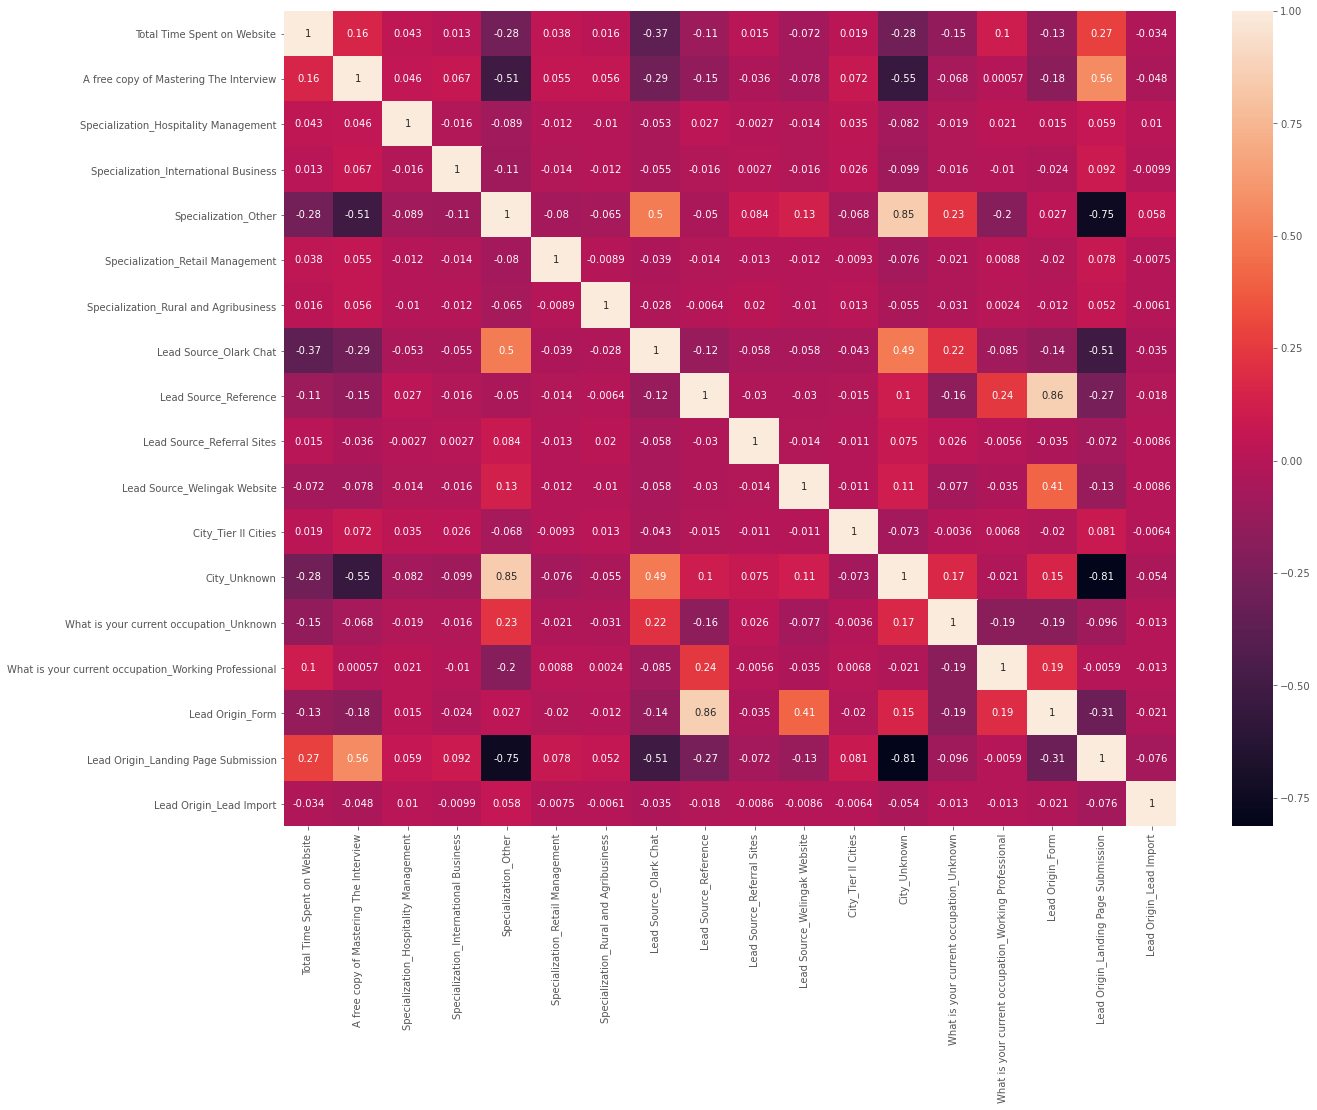

In [69]:
plt.figure(figsize=(20,15))
sns.heatmap(x_train.corr(),annot=True)

In [70]:
# Dropping 'Lead Origin_Landing Page Submission' as it has high correlation with multipal columns
x_train.drop('Lead Origin_Landing Page Submission',axis=1,inplace=True)

#### Adding constant variable 

In [71]:
# Adding constant to the x_train data
x_train = sm.add_constant(x_train)

#### Model 1

In [72]:
# Running Logestic Regression
model1 = sm.GLM(y_train,x_train,family=sm.families.Binomial())

# Displaying the summary
model1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6450
Model Family:                Binomial   Df Model:                           17
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2913.0
Date:                Mon, 14 Jun 2021   Deviance:                       5825.9
Time:                        17:55:08   Pearson chi2:                 7.50e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -0.5338      0.065     -8.262      0.000      -0.660      -0.407
Total Time Spent on Website                              1.0929      0.038     28.762      0.000       1.018       1.167
A free copy of Mastering The Interview                  -0.4082      0.083     -4.909      0.000      -0.571      -0.245
Specialization_Hospitality Management                   -1.0089      0.311     -3.245      0.001      -1.618      -0.399
Specialization_International Business                   -0.3650      0.250     -1.463      0.144      -0.854       0.124
Specialization_Other                                    -0.5496      0.146     -3.775      0.000      -0.835      -0.264
Specialization_Retail Management                        -0.4837      0.314     -1.539      0.124      -1.100       0.132
Specialization_Rural and Agribusiness                    0.4066      0.364      1.117      0.264      -0.307       1.120
Lead Source_Olark Chat                                   1.1398      0.109     10.478      0.000       0.927       1.353
Lead Source_Reference                                    0.5434      0.478      1.137      0.255      -0.393       1.480
Lead Source_Referral Sites                              -0.2378      0.303     -0.785      0.433      -0.832       0.356
Lead Source_Welingak Website                             2.7170      0.840      3.236      0.001       1.071       4.362
City_Tier II Cities                                     -0.4614      0.378     -1.222      0.222      -1.202       0.279
City_Unknown                                             0.0070      0.146      0.048      0.962      -0.280       0.294
What is your current occupation_Unknown                 -1.2147      0.083    -14.721      0.000      -1.376      -1.053
What is your current occupation_Working Professional     2.4522      0.182     13.497      0.000       2.096       2.808
Lead Origin_Form                                         2.9431      0.445      6.617      0.000       2.071       3.815
Lead Origin_Lead Import                                 -0.1679      0.534     -0.315      0.753      -1.214       0.878
========================================================================================================================
"""

In [73]:
# Checking VIF values
check_vif(x_train)

,Features,VIF
15,Lead Origin_Form,15.40
8,Lead Source_Reference,12.61
12,City_Unknown,7.23
4,Specialization_Other,6.92
10,Lead Source_Welingak Website,3.69
7,Lead Source_Olark Chat,1.98
13,What is your current occupation_Unknown,1.49
14,What is your current occupation_Working Profes...,1.26
0,Total Time Spent on Website,1.21
1,A free copy of Mastering The Interview,1.20


#### Model 2

In the first model, the feature **`Lead Origin_Form`** has a very high VIF value.

In [74]:
# Dropping 'Lead Origin_Form'
x_train.drop('Lead Origin_Form',axis=1,inplace=True)

# Running Logestic Regression
model2 = sm.GLM(y_train,x_train,family=sm.families.Binomial())

# Displaying the summary
model2.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6451
Model Family:                Binomial   Df Model:                           16
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2940.1
Date:                Mon, 14 Jun 2021   Deviance:                       5880.1
Time:                        17:55:09   Pearson chi2:                 7.44e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -0.4989      0.064     -7.790      0.000      -0.624      -0.373
Total Time Spent on Website                              1.0679      0.038     28.461      0.000       0.994       1.141
A free copy of Mastering The Interview                  -0.4247      0.083     -5.135      0.000      -0.587      -0.263
Specialization_Hospitality Management                   -1.0050      0.309     -3.248      0.001      -1.612      -0.399
Specialization_International Business                   -0.3748      0.248     -1.509      0.131      -0.862       0.112
Specialization_Other                                    -0.5402      0.145     -3.738      0.000      -0.823      -0.257
Specialization_Retail Management                        -0.4855      0.313     -1.553      0.121      -1.098       0.127
Specialization_Rural and Agribusiness                    0.3965      0.363      1.093      0.274      -0.314       1.107
Lead Source_Olark Chat                                   1.0487      0.107      9.806      0.000       0.839       1.258
Lead Source_Reference                                    3.4008      0.201     16.901      0.000       3.006       3.795
Lead Source_Referral Sites                              -0.2901      0.301     -0.963      0.335      -0.880       0.300
Lead Source_Welingak Website                             5.5513      0.721      7.697      0.000       4.138       6.965
City_Tier II Cities                                     -0.4613      0.376     -1.226      0.220      -1.199       0.276
City_Unknown                                             0.0557      0.145      0.383      0.702      -0.229       0.340
What is your current occupation_Unknown                 -1.2405      0.082    -15.110      0.000      -1.401      -1.080
What is your current occupation_Working Professional     2.4362      0.181     13.436      0.000       2.081       2.792
Lead Origin_Lead Import                                 -0.2107      0.531     -0.397      0.691      -1.251       0.829
========================================================================================================================
"""

In [75]:
# Checking VIF values
check_vif(x_train)

,Features,VIF
12,City_Unknown,7.21
4,Specialization_Other,6.92
7,Lead Source_Olark Chat,1.97
13,What is your current occupation_Unknown,1.48
14,What is your current occupation_Working Profes...,1.26
8,Lead Source_Reference,1.24
0,Total Time Spent on Website,1.20
1,A free copy of Mastering The Interview,1.20
10,Lead Source_Welingak Website,1.08
15,Lead Origin_Lead Import,1.05


#### Model 3

In the second model, the feature **`City_Unknown`** has a higher VIF value.

In [76]:
# Dropping 'City_Unknown'
x_train.drop('City_Unknown',axis=1,inplace=True)

# Running Logestic Regression
model3 = sm.GLM(y_train,x_train,family=sm.families.Binomial())

# Displaying the summary
model3.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6452
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2940.1
Date:                Mon, 14 Jun 2021   Deviance:                       5880.3
Time:                        17:55:09   Pearson chi2:                 7.41e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -0.4933      0.062     -7.909      0.000      -0.616      -0.371
Total Time Spent on Website                              1.0679      0.038     28.456      0.000       0.994       1.141
A free copy of Mastering The Interview                  -0.4306      0.081     -5.299      0.000      -0.590      -0.271
Specialization_Hospitality Management                   -1.0056      0.309     -3.249      0.001      -1.612      -0.399
Specialization_International Business                   -0.3757      0.248     -1.513      0.130      -0.862       0.111
Specialization_Other                                    -0.4967      0.089     -5.551      0.000      -0.672      -0.321
Specialization_Retail Management                        -0.4868      0.313     -1.556      0.120      -1.100       0.126
Specialization_Rural and Agribusiness                    0.3967      0.363      1.094      0.274      -0.314       1.107
Lead Source_Olark Chat                                   1.0554      0.106      9.999      0.000       0.849       1.262
Lead Source_Reference                                    3.4071      0.201     16.990      0.000       3.014       3.800
Lead Source_Referral Sites                              -0.2854      0.301     -0.948      0.343      -0.875       0.304
Lead Source_Welingak Website                             5.5548      0.721      7.703      0.000       4.141       6.968
City_Tier II Cities                                     -0.4629      0.376     -1.230      0.219      -1.200       0.274
What is your current occupation_Unknown                 -1.2403      0.082    -15.109      0.000      -1.401      -1.079
What is your current occupation_Working Professional     2.4416      0.181     13.512      0.000       2.087       2.796
Lead Origin_Lead Import                                 -0.2440      0.523     -0.466      0.641      -1.269       0.781
========================================================================================================================
"""

In [77]:
# Checking VIF values
check_vif(x_train)

,Features,VIF
4,Specialization_Other,2.09
7,Lead Source_Olark Chat,1.91
12,What is your current occupation_Unknown,1.47
0,Total Time Spent on Website,1.20
1,A free copy of Mastering The Interview,1.19
8,Lead Source_Reference,1.16
13,What is your current occupation_Working Profes...,1.16
10,Lead Source_Welingak Website,1.07
9,Lead Source_Referral Sites,1.04
2,Specialization_Hospitality Management,1.02


#### Model 4

In the third model, the feature **`Lead Origin_Lead Import`** has a high p-value, therefore will drop this from our model.

In [78]:
# Dropping 'Lead Origin_Lead Import'
x_train.drop('Lead Origin_Lead Import',axis=1,inplace=True)

# Running Logestic Regression
model4 = sm.GLM(y_train,x_train,family=sm.families.Binomial())

# Displaying the summary
model4.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6453
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2940.2
Date:                Mon, 14 Jun 2021   Deviance:                       5880.5
Time:                        17:55:09   Pearson chi2:                 7.41e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -0.4950      0.062     -7.948      0.000      -0.617      -0.373
Total Time Spent on Website                              1.0686      0.037     28.497      0.000       0.995       1.142
A free copy of Mastering The Interview                  -0.4294      0.081     -5.286      0.000      -0.589      -0.270
Specialization_Hospitality Management                   -1.0069      0.309     -3.255      0.001      -1.613      -0.401
Specialization_International Business                   -0.3752      0.248     -1.511      0.131      -0.862       0.112
Specialization_Other                                    -0.4991      0.089     -5.585      0.000      -0.674      -0.324
Specialization_Retail Management                        -0.4865      0.313     -1.555      0.120      -1.100       0.127
Specialization_Rural and Agribusiness                    0.3970      0.363      1.095      0.273      -0.314       1.108
Lead Source_Olark Chat                                   1.0594      0.105     10.067      0.000       0.853       1.266
Lead Source_Reference                                    3.4104      0.200     17.017      0.000       3.018       3.803
Lead Source_Referral Sites                              -0.2828      0.301     -0.940      0.347      -0.873       0.307
Lead Source_Welingak Website                             5.5593      0.721      7.710      0.000       4.146       6.973
City_Tier II Cities                                     -0.4626      0.376     -1.229      0.219      -1.200       0.275
What is your current occupation_Unknown                 -1.2398      0.082    -15.102      0.000      -1.401      -1.079
What is your current occupation_Working Professional     2.4407      0.181     13.510      0.000       2.087       2.795
========================================================================================================================
"""

In [79]:
# Checking VIF values
check_vif(x_train)

,Features,VIF
4,Specialization_Other,2.06
7,Lead Source_Olark Chat,1.90
12,What is your current occupation_Unknown,1.47
0,Total Time Spent on Website,1.20
1,A free copy of Mastering The Interview,1.19
8,Lead Source_Reference,1.16
13,What is your current occupation_Working Profes...,1.16
10,Lead Source_Welingak Website,1.07
9,Lead Source_Referral Sites,1.04
2,Specialization_Hospitality Management,1.02


#### Model 5

In the fourth model, the feature **`Lead Source_Referral Sites`** has a very large P - value, therefour will drop it from our model.

In [80]:
# Dropping 'Lead Source_Referral Sites'
x_train.drop('Lead Source_Referral Sites',axis=1,inplace=True)

# Running Logestic Regression
model5 = sm.GLM(y_train,x_train,family=sm.families.Binomial())

# Displaying the summary
model5.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6454
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2940.7
Date:                Mon, 14 Jun 2021   Deviance:                       5881.4
Time:                        17:55:09   Pearson chi2:                 7.41e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -0.4975      0.062     -7.995      0.000      -0.620      -0.376
Total Time Spent on Website                              1.0684      0.037     28.493      0.000       0.995       1.142
A free copy of Mastering The Interview                  -0.4288      0.081     -5.279      0.000      -0.588      -0.270
Specialization_Hospitality Management                   -1.0060      0.309     -3.252      0.001      -1.612      -0.400
Specialization_International Business                   -0.3762      0.248     -1.514      0.130      -0.863       0.111
Specialization_Other                                    -0.5083      0.089     -5.722      0.000      -0.682      -0.334
Specialization_Retail Management                        -0.4846      0.313     -1.549      0.121      -1.098       0.129
Specialization_Rural and Agribusiness                    0.3871      0.362      1.070      0.284      -0.322       1.096
Lead Source_Olark Chat                                   1.0696      0.105     10.212      0.000       0.864       1.275
Lead Source_Reference                                    3.4171      0.200     17.057      0.000       3.024       3.810
Lead Source_Welingak Website                             5.5705      0.721      7.726      0.000       4.157       6.984
City_Tier II Cities                                     -0.4598      0.376     -1.222      0.222      -1.197       0.278
What is your current occupation_Unknown                 -1.2401      0.082    -15.107      0.000      -1.401      -1.079
What is your current occupation_Working Professional     2.4381      0.181     13.493      0.000       2.084       2.792
========================================================================================================================
"""

In [81]:
# Checking VIF values
check_vif(x_train)

,Features,VIF
4,Specialization_Other,2.01
7,Lead Source_Olark Chat,1.87
11,What is your current occupation_Unknown,1.47
0,Total Time Spent on Website,1.20
1,A free copy of Mastering The Interview,1.19
8,Lead Source_Reference,1.16
12,What is your current occupation_Working Profes...,1.16
9,Lead Source_Welingak Website,1.07
2,Specialization_Hospitality Management,1.02
3,Specialization_International Business,1.02


#### Model 6

In the 5th model **`Specialization_Rural and Agribusiness`** have a higher P-value

In [82]:
# Dropping 'Specialization_Rural and Agribusiness'
x_train.drop('Specialization_Rural and Agribusiness',axis=1,inplace=True)

# Running Logestic Regression
model6 = sm.GLM(y_train,x_train,family=sm.families.Binomial())

# Displaying the summary
model6.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6455
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2941.3
Date:                Mon, 14 Jun 2021   Deviance:                       5882.5
Time:                        17:55:09   Pearson chi2:                 7.41e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -0.4933      0.062     -7.946      0.000      -0.615      -0.372
Total Time Spent on Website                              1.0679      0.037     28.490      0.000       0.994       1.141
A free copy of Mastering The Interview                  -0.4262      0.081     -5.251      0.000      -0.585      -0.267
Specialization_Hospitality Management                   -1.0107      0.309     -3.268      0.001      -1.617      -0.405
Specialization_International Business                   -0.3814      0.248     -1.536      0.125      -0.868       0.105
Specialization_Other                                    -0.5127      0.089     -5.777      0.000      -0.687      -0.339
Specialization_Retail Management                        -0.4895      0.313     -1.565      0.118      -1.102       0.123
Lead Source_Olark Chat                                   1.0707      0.105     10.222      0.000       0.865       1.276
Lead Source_Reference                                    3.4174      0.200     17.060      0.000       3.025       3.810
Lead Source_Welingak Website                             5.5700      0.721      7.725      0.000       4.157       6.983
City_Tier II Cities                                     -0.4559      0.377     -1.211      0.226      -1.194       0.282
What is your current occupation_Unknown                 -1.2418      0.082    -15.131      0.000      -1.403      -1.081
What is your current occupation_Working Professional     2.4351      0.181     13.482      0.000       2.081       2.789
========================================================================================================================
"""

In [83]:
# Checking VIF values
check_vif(x_train)

,Features,VIF
4,Specialization_Other,2.01
6,Lead Source_Olark Chat,1.87
10,What is your current occupation_Unknown,1.47
0,Total Time Spent on Website,1.20
1,A free copy of Mastering The Interview,1.18
7,Lead Source_Reference,1.16
11,What is your current occupation_Working Profes...,1.16
8,Lead Source_Welingak Website,1.07
2,Specialization_Hospitality Management,1.02
3,Specialization_International Business,1.02


In [84]:
top_corr(x_train)

,Var1,Var2,Correlations,Corr_abs
25,A free copy of Mastering The Interview,Specialization_Other,-0.509665,0.509665
51,Specialization_Other,Lead Source_Olark Chat,0.498444,0.498444
17,Total Time Spent on Website,Lead Source_Olark Chat,-0.369762,0.369762
27,A free copy of Mastering The Interview,Lead Source_Olark Chat,-0.291339,0.291339
15,Total Time Spent on Website,Specialization_Other,-0.281960,0.281960
71,Lead Source_Reference,What is your current occupation_Working Profes...,0.242100,0.242100
55,Specialization_Other,What is your current occupation_Unknown,0.225763,0.225763
66,Lead Source_Olark Chat,What is your current occupation_Unknown,0.219949,0.219949
56,Specialization_Other,What is your current occupation_Working Profes...,-0.199537,0.199537
77,What is your current occupation_Unknown,What is your current occupation_Working Profes...,-0.186591,0.186591


#### Model 7

**`City_Tier II Cities`** has a very high P-value.

In [85]:
# Dropping 'City_Tier II Cities'
x_train.drop('City_Tier II Cities',axis=1,inplace=True)

# Running Logestic Regression
model7 = sm.GLM(y_train,x_train,family=sm.families.Binomial())

# Displaying the summary
model7.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6456
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2942.0
Date:                Mon, 14 Jun 2021   Deviance:                       5884.0
Time:                        17:55:10   Pearson chi2:                 7.41e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -0.4955      0.062     -7.985      0.000      -0.617      -0.374
Total Time Spent on Website                              1.0674      0.037     28.494      0.000       0.994       1.141
A free copy of Mastering The Interview                  -0.4316      0.081     -5.325      0.000      -0.590      -0.273
Specialization_Hospitality Management                   -1.0250      0.309     -3.313      0.001      -1.631      -0.419
Specialization_International Business                   -0.3903      0.249     -1.569      0.117      -0.878       0.097
Specialization_Other                                    -0.5107      0.089     -5.756      0.000      -0.685      -0.337
Specialization_Retail Management                        -0.4839      0.313     -1.548      0.122      -1.097       0.129
Lead Source_Olark Chat                                   1.0716      0.105     10.233      0.000       0.866       1.277
Lead Source_Reference                                    3.4189      0.200     17.067      0.000       3.026       3.812
Lead Source_Welingak Website                             5.5699      0.721      7.725      0.000       4.157       6.983
What is your current occupation_Unknown                 -1.2431      0.082    -15.147      0.000      -1.404      -1.082
What is your current occupation_Working Professional     2.4324      0.180     13.478      0.000       2.079       2.786
========================================================================================================================
"""

In [86]:
# Checking VIF values
check_vif(x_train)

,Features,VIF
4,Specialization_Other,2.01
6,Lead Source_Olark Chat,1.87
9,What is your current occupation_Unknown,1.47
0,Total Time Spent on Website,1.20
1,A free copy of Mastering The Interview,1.18
7,Lead Source_Reference,1.16
10,What is your current occupation_Working Profes...,1.16
8,Lead Source_Welingak Website,1.07
2,Specialization_Hospitality Management,1.02
3,Specialization_International Business,1.02


#### Model 8

**`Specialization_Retail Management`** has a very high P-value.

In [87]:
# Dropping 'Specialization_Retail Management'
x_train.drop('Specialization_Retail Management',axis=1,inplace=True)

# Running Logestic Regression
model8 = sm.GLM(y_train,x_train,family=sm.families.Binomial())

# Displaying the summary
model8.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6457
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2943.3
Date:                Mon, 14 Jun 2021   Deviance:                       5886.5
Time:                        17:55:10   Pearson chi2:                 7.43e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -0.5031      0.062     -8.134      0.000      -0.624      -0.382
Total Time Spent on Website                              1.0661      0.037     28.484      0.000       0.993       1.139
A free copy of Mastering The Interview                  -0.4330      0.081     -5.344      0.000      -0.592      -0.274
Specialization_Hospitality Management                   -1.0157      0.309     -3.285      0.001      -1.622      -0.410
Specialization_International Business                   -0.3815      0.249     -1.534      0.125      -0.869       0.106
Specialization_Other                                    -0.5028      0.089     -5.677      0.000      -0.676      -0.329
Lead Source_Olark Chat                                   1.0700      0.105     10.222      0.000       0.865       1.275
Lead Source_Reference                                    3.4193      0.200     17.073      0.000       3.027       3.812
Lead Source_Welingak Website                             5.5689      0.721      7.724      0.000       4.156       6.982
What is your current occupation_Unknown                 -1.2425      0.082    -15.139      0.000      -1.403      -1.082
What is your current occupation_Working Professional     2.4293      0.180     13.465      0.000       2.076       2.783
========================================================================================================================
"""

In [88]:
# Checking VIF values
check_vif(x_train)

,Features,VIF
4,Specialization_Other,2.01
5,Lead Source_Olark Chat,1.87
8,What is your current occupation_Unknown,1.47
0,Total Time Spent on Website,1.20
1,A free copy of Mastering The Interview,1.17
6,Lead Source_Reference,1.16
9,What is your current occupation_Working Profes...,1.16
7,Lead Source_Welingak Website,1.07
2,Specialization_Hospitality Management,1.02
3,Specialization_International Business,1.02


#### Model 9

**`Specialization_International Business`** has a very high P-value.

In [89]:
# Dropping 'Specialization_International Business'
x_train.drop('Specialization_International Business',axis=1,inplace=True)

# Running Logestic Regression
model9 = sm.GLM(y_train,x_train,family=sm.families.Binomial())

# Displaying the summary
model9.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6458
Model Family:                Binomial   Df Model:                            9
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2944.5
Date:                Mon, 14 Jun 2021   Deviance:                       5888.9
Time:                        17:55:10   Pearson chi2:                 7.43e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -0.5146      0.061     -8.378      0.000      -0.635      -0.394
Total Time Spent on Website                              1.0668      0.037     28.507      0.000       0.993       1.140
A free copy of Mastering The Interview                  -0.4331      0.081     -5.348      0.000      -0.592      -0.274
Specialization_Hospitality Management                   -1.0055      0.309     -3.251      0.001      -1.612      -0.399
Specialization_Other                                    -0.4918      0.088     -5.570      0.000      -0.665      -0.319
Lead Source_Olark Chat                                   1.0712      0.105     10.234      0.000       0.866       1.276
Lead Source_Reference                                    3.4227      0.200     17.092      0.000       3.030       3.815
Lead Source_Welingak Website                             5.5705      0.721      7.726      0.000       4.157       6.984
What is your current occupation_Unknown                 -1.2425      0.082    -15.142      0.000      -1.403      -1.082
What is your current occupation_Working Professional     2.4345      0.180     13.494      0.000       2.081       2.788
========================================================================================================================
"""

In [90]:
# Checking VIF values
check_vif(x_train)

,Features,VIF
3,Specialization_Other,2.00
4,Lead Source_Olark Chat,1.87
7,What is your current occupation_Unknown,1.47
0,Total Time Spent on Website,1.20
5,Lead Source_Reference,1.16
8,What is your current occupation_Working Profes...,1.16
1,A free copy of Mastering The Interview,1.15
6,Lead Source_Welingak Website,1.07
2,Specialization_Hospitality Management,1.02


#### Assessing the Model

In [91]:
# Getting the predicted values on the train set
y_train_pred = model9.fit().predict(x_train)

# Checking y_train_pred
y_train_pred[:10]

1871    0.404206
6795    0.192557
3516    0.337857
8105    0.719467
3934    0.293225
4844    0.980301
3297    0.151050
8071    0.993718
987     0.167620
7423    0.750268
dtype: float64

In [92]:
# Creating DataFrame of actual, probability(Lead Score) 
y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'Convert_Prob':y_train_pred})

# Checking y_train_pred_final
y_train_pred_final.sort_index().head()

,Converted,Convert_Prob
1,0,0.346308
2,1,0.749921
4,1,0.697732
5,0,0.106949
6,1,0.850960


In [93]:
# Making predictions using 0.5 as cut off value
y_train_pred_final['predicted'] = y_train_pred_final['Convert_Prob'].map(lambda x: 1 if x > 0.5 else 0)

# Checking the head of the data
y_train_pred_final.sort_index().head()

,Converted,Convert_Prob,predicted
1,0,0.346308,0
2,1,0.749921,1
4,1,0.697732,1
5,0,0.106949,0
6,1,0.850960,1


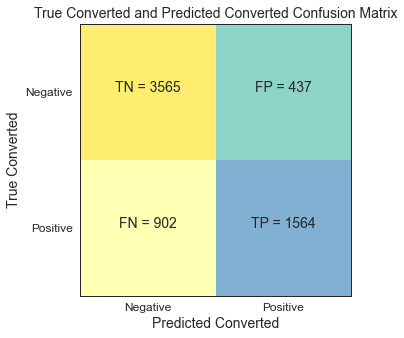

In [94]:
confusion = metrics.confusion_matrix(y_train_pred_final['Converted'],y_train_pred_final['predicted'])
plot_confusion(confusion)

In [95]:
# Getting the required metrics
get_metrics(y_train_pred_final['Converted'], y_train_pred_final['predicted'])

The Accuracy is    : 0.79 (0.7929808286951144)
The Sensitivity is : 0.63 (0.6342254663422546)
The Specificity is : 0.89 (0.8908045977011494)
The Precision is   : 0.78 (0.7816091954022989)
The Recall is      : 0.63 (0.6342254663422546)
The f1 score is    : 0.7 (0.7002462502798298)


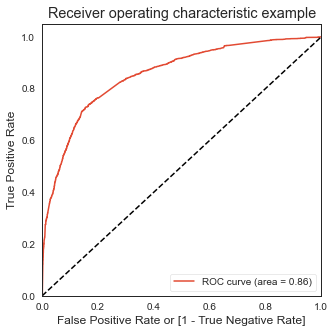

In [96]:
# Plotting the ROC
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Convert_Prob)

#### Finding the optimal cutoff point

In [97]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final['Convert_Prob'].map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Converted,Convert_Prob,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
1871,0,0.404206,0,1,1,1,1,1,0,0,0,0,0
6795,0,0.192557,0,1,1,0,0,0,0,0,0,0,0
3516,0,0.337857,0,1,1,1,1,0,0,0,0,0,0
8105,0,0.719467,1,1,1,1,1,1,1,1,1,0,0
3934,0,0.293225,0,1,1,1,0,0,0,0,0,0,0


In [98]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final['Converted'], y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
cutoff_df.fillna(0,inplace=True)
cutoff_df

,prob,accuracy,sensi,speci
0.0,0.0,0.381262,1.000000,0.000000
0.1,0.1,0.492115,0.986212,0.187656
0.2,0.2,0.684910,0.894566,0.555722
0.3,0.3,0.788188,0.763179,0.803598
0.4,0.4,0.801948,0.711273,0.857821
0.5,0.5,0.792981,0.634225,0.890805
0.6,0.6,0.780921,0.563260,0.915042
0.7,0.7,0.763296,0.469992,0.944028
0.8,0.8,0.740569,0.364152,0.972514
0.9,0.9,0.693414,0.206407,0.993503


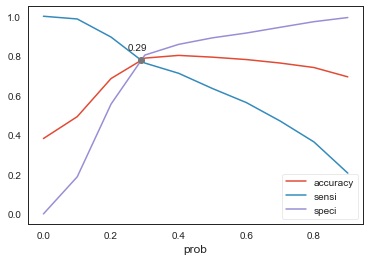

In [99]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])

# accuracy = LineString(np.column_stack((cutoff_df['prob'],cutoff_df['accuracy'])))
sensi = LineString(np.column_stack((cutoff_df['prob'],cutoff_df['sensi'])))
speci = LineString(np.column_stack((cutoff_df['prob'],cutoff_df['speci'])))

# Finding the point of intersection
intersection = sensi.intersection(speci)

# Plotting the point of intersection
plt.plot(*intersection.xy,'o')

# Annotation for the point of intersection
plt.annotate(round(intersection.x,2), xy = (intersection.x,intersection.y),xytext=(intersection.x-0.04,intersection.y+0.05))

# Displaying the lengend
plt.legend(loc='lower right')

# Displaying the plot
plt.show()

We can clearly see that the optimul cutoff value is 0.31

In [100]:
# Making prediction with the optimum cut off value
y_train_pred_final['final_predicted'] = y_train_pred_final['Convert_Prob'].map( lambda x: 1 if x > 0.293 else 0)

# Checking the final prediction
y_train_pred_final.head()

,Converted,Convert_Prob,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
1871,0,0.404206,0,1,1,1,1,1,0,0,0,0,0,1
6795,0,0.192557,0,1,1,0,0,0,0,0,0,0,0,0
3516,0,0.337857,0,1,1,1,1,0,0,0,0,0,0,1
8105,0,0.719467,1,1,1,1,1,1,1,1,1,0,0,1
3934,0,0.293225,0,1,1,1,0,0,0,0,0,0,0,1


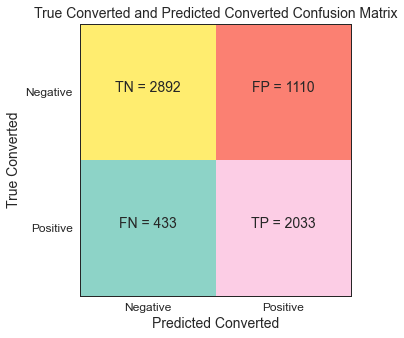

In [101]:
# Geting the confusion matrix
confusion = metrics.confusion_matrix(y_train_pred_final['Converted'], y_train_pred_final['final_predicted'])

# Plotting the confusion matrix
plot_confusion(confusion)

In [102]:
# Getting all the required metrics to evaluate the model
get_metrics(y_train_pred_final['Converted'], y_train_pred_final['final_predicted'])

The Accuracy is    : 0.76 (0.7614409400123686)
The Sensitivity is : 0.82 (0.82441200324412)
The Specificity is : 0.72 (0.7226386806596702)
The Precision is   : 0.65 (0.6468342348075088)
The Recall is      : 0.82 (0.82441200324412)
The f1 score is    : 0.72 (0.7249064004278837)


### Precision and recall tradeoff

In [103]:
# Getting the required data for plotting the precision and recall
p, r, thresholds = precision_recall_curve(y_train_pred_final['Converted'], y_train_pred_final['Convert_Prob'])

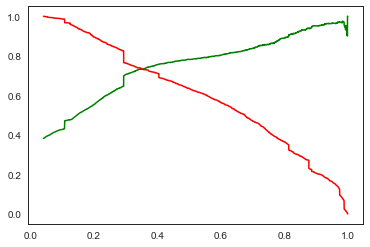

In [104]:
# Plotting the precision
plt.plot(thresholds, p[:-1], "g-")

# Plotting the recall
plt.plot(thresholds, r[:-1], "r-")

# Displaying the plot
plt.show()

## Making predictions on the test set

In [105]:
# Scaling the features of the test data
x_test[['Total Time Spent on Website','Page Views Per Visit','TotalVisits']]= scaler.transform(
                                                x_test[['Total Time Spent on Website','Page Views Per Visit','TotalVisits']])

In [106]:
# Adding constant to the x test data
x_test = sm.add_constant(x_test)

# Keeping only the required features
x_test = x_test[x_train.columns]

# Checking the test data
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2772 entries, 4269 to 2960
Data columns (total 10 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   const                                                 2772 non-null   float64
 1   Total Time Spent on Website                           2772 non-null   float64
 2   A free copy of Mastering The Interview                2772 non-null   int64  
 3   Specialization_Hospitality Management                 2772 non-null   uint8  
 4   Specialization_Other                                  2772 non-null   uint8  
 5   Lead Source_Olark Chat                                2772 non-null   uint8  
 6   Lead Source_Reference                                 2772 non-null   uint8  
 7   Lead Source_Welingak Website                          2772 non-null   uint8  
 8   What is your current occupation_Unknown               2

Making predictions on the test set

In [107]:
# Getting the probability of conversion
y_test_pred = model9.fit().predict(x_test)

In [108]:
# Creating a DataFrame to store the probablities 
y_test_pred = pd.DataFrame(y_test_pred)

# Renanaming the column
y_test_pred= y_test_pred.rename(columns={ 0 : 'Convert_Prob'})

# Checking the newly created DataFrame
y_test_pred.head()

,Convert_Prob
4269,0.227938
2376,0.813318
7766,0.748480
9199,0.293225
4359,0.876913


In [109]:
# Appending y_test_df and y_pred_1
y_test_pred = pd.concat([y_test, y_test_pred],axis=1)

# Checking the head
y_test_pred.head()

,Converted,Convert_Prob
4269,1,0.227938
2376,1,0.813318
7766,1,0.748480
9199,0,0.293225
4359,1,0.876913


In [110]:
# Making our predictions using the cutoff value
y_test_pred['final_predicted'] = y_test_pred.Convert_Prob.map(lambda x: 1 if x > 0.293 else 0)

In [111]:
# Checking the head
y_test_pred.head()

,Converted,Convert_Prob,final_predicted
4269,1,0.227938,0
2376,1,0.813318,1
7766,1,0.748480,1
9199,0,0.293225,1
4359,1,0.876913,1


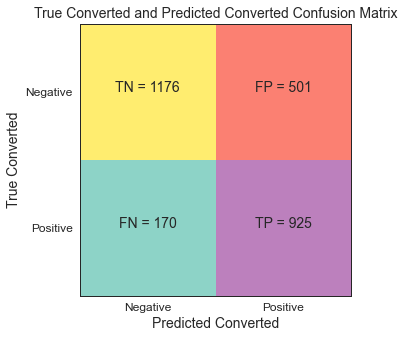

In [112]:
# Confusion matrics
confusion = metrics.confusion_matrix(y_test_pred['Converted'],y_test_pred['final_predicted'])

# Plotting the confusion matrics
plot_confusion(confusion)

In [113]:
# Getting all the required metrics to evaluate the model
get_metrics(y_test_pred['Converted'],y_test_pred['final_predicted'])

The Accuracy is    : 0.76 (0.7579365079365079)
The Sensitivity is : 0.84 (0.8447488584474886)
The Specificity is : 0.7 (0.7012522361359571)
The Precision is   : 0.65 (0.6486676016830295)
The Recall is      : 0.84 (0.8447488584474886)
The f1 score is    : 0.73 (0.7338357794525983)


# Lead scoring

In [114]:
y_test_pred['Lead_Score'] = round(y_test_pred['Convert_Prob']*100,2)

Lead_score = y_test_pred[['final_predicted','Lead_Score']]

Lead_score.head()

,final_predicted,Lead_Score
4269,0,22.79
2376,1,81.33
7766,1,74.85
9199,1,29.32
4359,1,87.69


# Comparing the values obtained for Train & Test:

Train Data:
- Accuracy : 76 %
- Sensitivity : 82 %
- Specificity : 72 %

Test Data:
- Accuracy : 76 %
- Sensitivity : 84 %
- Specificity : 70 %


Thus we have achieved our goal of getting a ballpark of the target lead conversion rate to be around 80% . The Model seems to predict the Conversion Rate very well and we should be able to give the CEO confidence in making good calls based on this model to get a higher lead conversion rate of 80%.

# Recommendations
X Education Company needs to focus on following key aspects to improve the overall conversion rate:

- Increase user engagement on Welingak website since this helps in higher conversion.
- Focus on Working Professional which has high conversion certainty.
- Give incentives to improve the amount Referrals this would give a boost to the conversion rate.
- Make the user spend more time on the website which would also increase the chance of conversion, one recommended way to increase the time spent on the website is to give free content or free intro to the course.
- Improve the Olark Chat service, improving the response time, connecting to the right person etc..
- Make sure that the users visiting the website give information as to their specialization, current occupation, etc by making the user register or fill a form.